In [1]:
%matplotlib inline
import math

import numpy as np
import matplotlib.pyplot as plt

from linalg_helper import *
from plot_helper import *

In [198]:
dim = 10
N = 10000
trials = 1
is_aligned_with_max_eigvec = True;

In [199]:
def make_mult_diag(big, scale, dim):
    return np.diag([big *(scale)**i for i in range(dim)])

#A = make_random_diagonal_matrix(dim, 1.1, 0.9, 1)
A = make_mult_diag(1.1, 0.9, dim)
Q = make_random_subspace(dim, dim)
A_bar = Q @ A @ Q.T

x_init = make_random_direction(dim)

# Find largest eigenvalue and corresponding eigenvector
max_eig_index = max(zip(range(dim), np.diagonal(A)), key=lambda x: x[1])[0]
max_eigvec = np.array(Q[:,max_eig_index])
max_eig = np.diag(A)[max_eig_index]

max_eig_mat = max_eig * np.outer(max_eigvec, max_eigvec)

K = -max_eig * np.eye(dim)#- np.mean(np.diag(A))*np.eye(dim)

if is_aligned_with_max_eigvec:
    x_init = np.array(max_eigvec)

from heapq import nlargest

how_many_big = 10

print('{0} largest eigenvalues of matrix'.format(how_many_big))
for e in nlargest(how_many_big, np.diagonal(A)):
    print(e)
    
# Simulate and plot the state evolution without input for a short time and a long time
x_free = simulate_free_response(A_bar, N, x_init)
def obs_trial_law(obs_vecs, trial):
    def law(i, state_row):
        d_t = obs_vecs[N*trial + i, :]
        k = 0.0
        beta = d_t.dot(max_eigvec)
        # change this condition so that it tanks it every time it notices a multiplier that will make it drop?
        # something like a running history of sorts
        # The threshold seems to control the periodicity of the tanking (sloping down). If only I could do that to the main state!
        if (beta ** 2) < ( 1 - 1/max_eig):
            k = 1.0
        # maybe generate that U subspace here and subtract it?
        #a1 = np.dot(max_eigvec.T,d_t)
        #a_other = sum(Q[:,1:].T @ d_t)
        #return (-(max_eig) * np.outer(max_eigvec, d_t)/a1).dot(state_row) *k
        return (- np.outer(d_t,d_t)).dot(state_row)
    return law

def simulate_controlled_response_genie(A, N, x_init, law):
    dim = A.shape[0]
    x = np.zeros([N, dim])
    x[0, :] = x_init
    for i in range(N-1):
        Q = make_random_subspace(dim, dim)
        A_b = Q@A@Q.T
        x[i+1, :] = A_b.dot(x[i,:])+law(i, x[i,:])
    return x

10 largest eigenvalues of matrix
1.1
0.9900000000000001
0.8910000000000001
0.8019000000000002
0.7217100000000001
0.6495390000000001
0.5845851000000001
0.5261265900000002
0.47351393100000017
0.42616253790000014


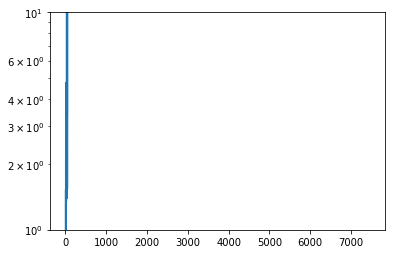

In [200]:
obs_vecs = np.array([make_random_direction(dim) for i in range (N*trials)])
obs = np.array([np.einsum('ij,ij->i', obs_vecs[N*i:N*(i+1), :], x_free) for i in range (trials)])
plt.plot(abs(obs.T))
plt.yscale('log'); 

x_cont = np.array([simulate_controlled_response(A, N, x_init, obs_trial_law(obs_vecs, i)) for i in range(trials)])

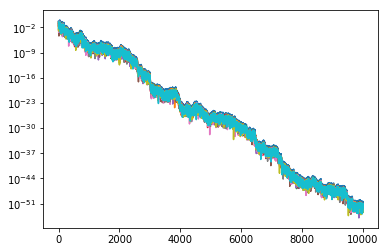

In [201]:
for i in range(trials):
    plt.plot(abs(x_cont[i,:,:]))
    plt.yscale('log');

Observation: It doesn't seem that great. Control law performance seems to have dependence on max lambda, which is stronger a relation than the dependence on initial condition, as well as dimension.

In [ ]:
def obs_trial_law2(trial):
    def law(i, state_row):
        y_t = obs[trial,i]
        u = -max_eig * y_t * dim * max_eigvec
        return u
    return law

x_cont2 = np.array([simulate_controlled_response(A_bar, N, x_init, obs_trial_law2(i)) for i in range(trials)])

In [ ]:
for i in range(trials):
    plt.plot(abs(x_cont2[i,:,:]))
    plt.yscale('log');